In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import plotly.express as px
import math

#### beta=relation of a stock with nifty
#### purpose :- build a portfolio such that there is a fixed return regardless of the direction of the market

In [112]:
# Define stock symbols and time period
stocks = ["TATASTEEL.NS", "ONGC.NS", "INDIACEM.NS", "INDUSTOWER.NS", "SUNDARMHLD.NS"]
market_symbol = "^NSEI"  # NSE Nifty 50 index symbol
risk_free_rate = 0.0002685  # daily value based on the current risk-free rate
market_risk_premium = 0.0003054  # Adjust this value based on historical data


start_date = "2023-04-30"
end_date = "2023-8-11"

In [133]:
# Download historical data for stocks and market

#data = yf.download(stocks + [market_symbol],start=start_date, end=end_date )["Adj Close"]
data = yf.download(stocks + [market_symbol],period='3mo',interval='1d' )["Adj Close"]
data

[*********************100%***********************]  6 of 6 completed


,INDIACEM.NS,INDUSTOWER.NS,ONGC.NS,SUNDARMHLD.NS,TATASTEEL.NS,^NSEI
Date,,,,,,
2023-05-11,196.750000,151.449997,167.050003,84.163605,105.119095,18297.000000
2023-05-12,194.050003,148.149994,165.500000,83.668816,103.375984,18314.800781
2023-05-15,193.750000,150.399994,165.600006,83.470894,104.295959,18398.849609
2023-05-16,193.750000,154.600006,168.000000,83.421417,104.005447,18286.500000
2023-05-17,194.300003,151.449997,167.250000,83.470894,102.649689,18181.750000
...,...,...,...,...,...,...
2023-08-07,215.750000,173.699997,172.949997,123.000000,118.849998,19597.300781
2023-08-08,215.100006,172.050003,173.350006,120.800003,118.150002,19570.849609
2023-08-09,229.149994,171.399994,176.899994,116.500000,120.199997,19632.550781


In [134]:
# Calculate daily returns for stocks and market
returns = data.pct_change().dropna()

# Separate the market returns from the returns dataframe
market_returns = returns[market_symbol]
stock_returns = returns.drop(columns=[market_symbol])

In [135]:
# Calculate the excess market returns (market risk premium)
excess_market_returns = market_returns - risk_free_rate

In [136]:
# Perform linear regression to calculate betas
betas = []
for stock in stocks:
    X = sm.add_constant(excess_market_returns)
    y = stock_returns[stock]
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # Slope coefficient (beta)
    betas.append(beta)

In [137]:
# Adjust beta for market risk premium
adj_betas = [beta * (1 + market_risk_premium) for beta in betas]

# Display the calculated adjusted betas
for i, stock in enumerate(stocks):
    print(f"Adjusted Beta of {stock}: {adj_betas[i]}")

Adjusted Beta of TATASTEEL.NS: 1.2398217479187974
Adjusted Beta of ONGC.NS: 0.35084561427128663
Adjusted Beta of INDIACEM.NS: 0.7270992304082456
Adjusted Beta of INDUSTOWER.NS: 1.4948859674010193
Adjusted Beta of SUNDARMHLD.NS: -0.5771919898478415


In [138]:
total_amount=16487
division=np.array([5620,3350,2566,2531,2420])
total_stocks=np.array([50,20,12,15,19])
weightage=division/total_amount

In [139]:
beta_portfolio=weightage.T @ betas
beta_portfolio

0.7516124800148019

In [140]:
data["portfolio"]=np.matmul(total_stocks.T,[data["TATASTEEL.NS"],data["ONGC.NS"],data["INDIACEM.NS"],data["INDUSTOWER.NS"],data["SUNDARMHLD.NS"]])

In [141]:
portfolio_return=data["portfolio"].pct_change().dropna()
portfolio_return.shape

(65,)

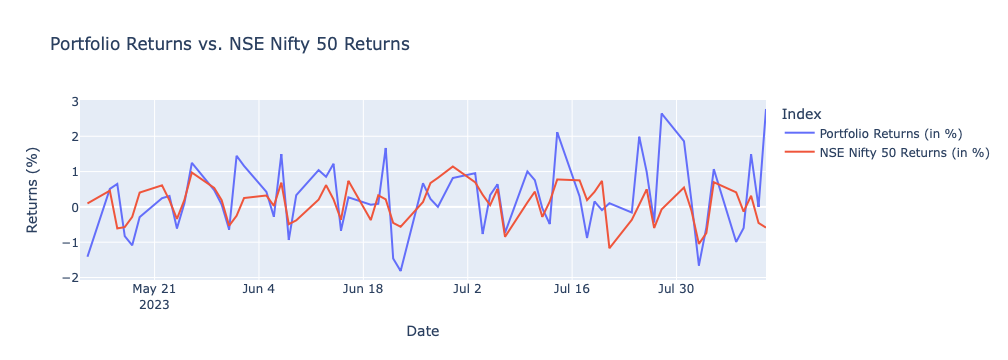

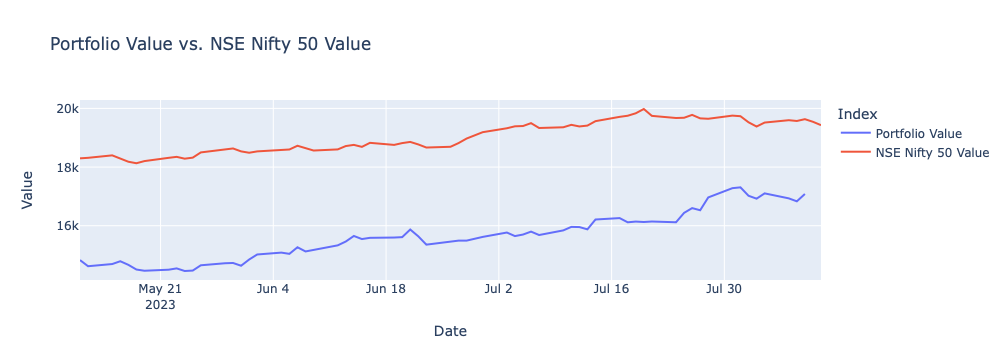

In [142]:
# Create a new dataframe for visualization (returns)
visualization_data_returns = pd.DataFrame({
    "Date": data.index,
    "Portfolio Returns (in %)": data["portfolio"].pct_change() * 100,
    "NSE Nifty 50 Returns (in %)": data[market_symbol].pct_change() * 100
})


# Filter out weekends from the data
filtered_data = data[data.index.weekday < 5]

# Create a new dataframe for visualization (returns)
visualization_data_returns = pd.DataFrame({
    "Date": filtered_data.index,
    "Portfolio Returns (in %)": filtered_data["portfolio"].pct_change() * 100,
    "NSE Nifty 50 Returns (in %)": filtered_data[market_symbol].pct_change() * 100
})

# Plot using Plotly for interactivity (returns)
fig_returns = px.line(visualization_data_returns, x="Date", y=["Portfolio Returns (in %)", "NSE Nifty 50 Returns (in %)"],
                      labels={"value": "Returns (%)", "variable": "Index"},
                      title="Portfolio Returns vs. NSE Nifty 50 Returns")
fig_returns.show()

# Create a new dataframe for visualization (values)
visualization_data_values = pd.DataFrame({
    "Date": filtered_data.index,
    "Portfolio Value": filtered_data["portfolio"],
    "NSE Nifty 50 Value": filtered_data[market_symbol]
})

# Plot using Plotly for interactivity (values)
fig_values = px.line(visualization_data_values, x="Date", y=["Portfolio Value", "NSE Nifty 50 Value"],
                     labels={"value": "Value", "variable": "Index"},
                     title="Portfolio Value vs. NSE Nifty 50 Value")
fig_values.show()

In [143]:
market_annual_ret=(1+market_returns).cumprod()[-1]**(252/market_returns.shape[0])-1 # annual return compounded from daily return
weeky_market_ret=100*((1+market_annual_ret)**(1/52)-1)

x=0.99
w=np.array([x,1-x])

equity_ret= 4*weeky_market_ret
derivative_return= -30

total_ret=equity_ret*w[0] + derivative_return*w[1]
total_ret # in percentage

1.4752367187095197

In [111]:
(1+data["portfolio"].pct_change().dropna()).cumprod()-1

Date
2023-05-03   -0.010860
2023-05-04   -0.002639
2023-05-05   -0.010370
2023-05-08    0.000705
2023-05-09   -0.002256
                ...   
2023-07-24    0.089227
2023-07-25    0.110873
2023-07-26    0.121858
2023-07-27    0.116938
2023-07-28    0.146471
Name: portfolio, Length: 62, dtype: float64

In [312]:
beta_portfolio

1.3398279495051795